We started playing with Pytorch and their toy datasets to get familiar with it. We plan to use Pytorch for our project. 

In [60]:
# code inspiration from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [61]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 32

# get the dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# create dataloaders for minibatch generation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

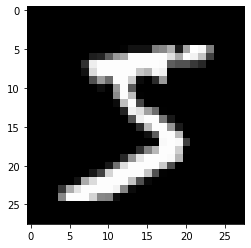

In [62]:
plt.imshow(trainset.data[0],cmap='gray')
plt.show()

# Model

In [63]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, prob):
        super().__init__()
        # filter weight shape: (1, 10, 5, 5)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        
        self.pool = nn.MaxPool2d(2, 2)

        # filter weight shape: (10, 20, 5, 5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)

        self.fc1 = nn.Linear(20 * 4 * 4, 120)
        self.dropout = nn.Dropout(prob)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# net = Net(0).to(device)

In [64]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [65]:
def get_loss_and_accuracy(images, labels, net, criterion):
    logits = net(images)
    loss = criterion(logits, labels)
    pred = logits.argmax(dim=1, keepdim=True)
    correct = pred.eq(labels.view_as(pred)).sum().item()
    return loss, correct

In [66]:
def test(dataloader, net, criterion):
    test_loss, test_accuracy = 0.0, 0.0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            loss, accuracy = get_loss_and_accuracy(images, labels, net, criterion)
            test_loss += loss
            test_accuracy += accuracy
    
    return test_loss.cpu().detach().numpy() / len(dataloader), test_accuracy * 100 / len(dataloader.dataset)

In [73]:
from tqdm import tqdm

losses = []
accuracies = []
test_accuracies = []

# train the model for X epochs
for n in range(10):
    prob = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    net = Net(prob[n]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    print(prob[n])
    for epoch in (range(10)): #tqdm
        running_loss = 0.0
        running_accuracy = 0.0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            loss, accuracy = get_loss_and_accuracy(images, labels, net, criterion)

            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().detach().numpy()
            running_accuracy += accuracy

        losses.append(running_loss / len(trainloader))
        accuracies.append(running_accuracy * 100 / len(trainloader.dataset))

        if epoch == 0:

            test_loss, test_accuracy = test(testloader, net, criterion)
            print(f'\n\ntest loss: {test_loss}\ntest accuracy: {test_accuracy} %')
            test_accuracies.append(test_accuracy)



    test_loss, test_accuracy = test(testloader, net, criterion)
    print(f'\n\ntest loss: {test_loss}\ntest accuracy: {test_accuracy} %')
    test_accuracies.append(test_accuracy)

0


test loss: 0.16752449011269469
test accuracy: 94.77 %


test loss: 0.03688461864337373
test accuracy: 98.81 %
0.1


test loss: 0.2016776209822097
test accuracy: 93.8 %


test loss: 0.04166584807082106
test accuracy: 98.57 %
0.2


test loss: 0.25736278009871705
test accuracy: 92.29 %


test loss: 0.04099647838848468
test accuracy: 98.68 %
0.3


test loss: 0.2537253626619284
test accuracy: 92.36 %


test loss: 0.05511922501146603
test accuracy: 98.1 %
0.4


test loss: 0.3146739143152206
test accuracy: 90.76 %


test loss: 0.059714558025518547
test accuracy: 98.09 %
0.5


test loss: 0.3998136185228634
test accuracy: 87.67 %


test loss: 0.06707246311175556
test accuracy: 97.92 %
0.6


test loss: 0.4027418435191194
test accuracy: 87.82 %


test loss: 0.08070858598898013
test accuracy: 97.6 %
0.7


test loss: 0.4766224139033796
test accuracy: 85.3 %


test loss: 0.10295426731292433
test accuracy: 96.74 %
0.8


test loss: 0.6378344941063049
test accuracy: 78.57 %


test loss: 0.136677714

In [74]:
print(test_accuracies)

[94.77, 98.81, 93.8, 98.57, 92.29, 98.68, 92.36, 98.1, 90.76, 98.09, 87.67, 97.92, 87.82, 97.6, 85.3, 96.74, 78.57, 95.55, 52.8, 83.31]
